<a href="https://colab.research.google.com/github/sfikas/graphics_course_code/blob/main/raytracing/raytracing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ένας απλός Raytracer
### Μέρος 2ο

In [4]:
import numpy as np 
from PIL import Image
from matplotlib import pyplot as plt

BACKGROUND_COLOR = (255, 255, 255)
Ch = Cw = 500
Vw = 1          
Vh = 1
d = 1           # Η απόσταση της κάμερας από το επίπεδο προβολής


class Sphere():
    def __init__(self, center, radius, color):
        self.center = np.array(center, dtype=np.float64)
        self.radius = np.float64(radius)
        self.color = np.array(color, dtype=np.float64)
    def __repr__(self) -> str:
        return('A sphere centered at {}, with radius {} and color {}.'.format(self.center, self.radius, self.color))

class Light():
    def __init__(self, type=None, intensity=None, position=None, direction=None):
        self.type = type
        self.intensity = intensity
        self.position = position
        self.direction = direction
    def __repr__(self) -> str:
        if self.type == 'ambient':
            text = 'An ambient light with intensity = {}.'.format(self.intensity)
        elif self.type == 'point':
            text = 'A point light at position = {} with intensity = {}'.format(self.position, self.intensity)
        elif self.type == 'directional':
            text = 'A directional light directed towards {} with intensity = {}'.format(self.direction, self.intensity)
        return(text)


class Framebuffer():
    def __init__(self, height=Ch, width=Cw):
        self.data = np.zeros([height, width, 3])

    def putPixel(self, x, y, color):
        # Αυτή η συνάρτηση 'βάφει' το pixel στις συντεταγμένες (x,y) με το χρώμα 'color'. 
        # To 'color' πρέπει να είναι τριάδα τιμών, πχ: (255, 0, 0) για το κόκκινο, ή (127, 127, 127) για γκρί.
        imagedimensions = self.data.shape
        x1 = x + imagedimensions[1] // 2
        y1 = -y + imagedimensions[0] // 2
        if(y1 < 0 or y1 >= imagedimensions[0]):
            return
        if(x1 < 0 or x1 >= imagedimensions[1]):
            return
        self.data[y1, x1, :] = np.array(color)

    def show(self):
        #plt.imshow(self.data, interpolation='bilinear')
        plt.imshow(np.uint8(self.data))
        plt.show()

    def saveToFile(self, fn='/tmp/raytracer.png'):
        Image.fromarray(np.uint8(self.data)).save(fn)
        


# Τα αντικείμενα της σκηνής
scene_spheres = [ 
    Sphere(center=(0, -1, 3), radius=1, color=(255, 0, 0)),
    Sphere(center=(2,  0, 4), radius=1, color=(0, 0, 255)),
    Sphere(center=(-2, 0, 4), radius=1, color=(0, 255, 0)),
    Sphere(center=(0, -5001, 0), radius=5000, color=(255, 255, 0))
]
# Τα φώτα της σκηνής
scene_lights = [
    Light(type='ambient', intensity=0.2),
    Light(type='point', intensity=0.2, position=(2, 1, 0)),
    Light(type='directional', intensity=0.6, direction=(1, 4, 4))
] 

def canvasToViewPort(x, y):
    '''
    Αυτή η συνάρτηση θα μετατρέψει τις συντεταγμένες οθόνης σε συντεταγμένες κόσμου (ΣΣΚ, WCS).
    '''
    return(np.array([x*Vw/Cw, y*Vh/Ch, d]))

def dot(a,b):
    '''
    Αυτή η συνάρτηση θα υπολογίσει το εσωτερικό γινόμενο των διανυσμάτων a,b.
    '''
    return(a[0]*b[0] + a[1]*b[1] + a[2]*b[2])

def length(a):
    res = a[0]**2 + a[1]**2 + a[2]**2
    return(np.sqrt(res))

def intersectRaySphere(O, D, sphere):
    r = sphere.radius
    CO = O - sphere.center
    a = dot(D, D)
    b = 2*dot(CO, D)
    c = dot(CO, CO) - r*r

    discriminant = b*b - 4*a*c
    if discriminant < 0:
        return(np.inf, np.inf)
    
    t1 = (-b + np.sqrt(discriminant)) / (2*a)
    t2 = (-b - np.sqrt(discriminant)) / (2*a)
    return t1, t2

def traceRay(O, D, t_min, t_max):
    closest_t = np.inf 
    closest_sphere = None
    for sphere in scene_spheres:
        t1, t2 = intersectRaySphere(O, D, sphere)
        if t1 >= t_min and t1 <= t_max and t1 < closest_t:
            closest_t = t1
            closest_sphere = sphere
        if t2 >= t_min and t2 <= t_max and t2 < closest_t: #Refactor ??
            closest_t = t2
            closest_sphere = sphere
    if closest_sphere is None:
        return(BACKGROUND_COLOR)
    #return closest_sphere.color   Σβήστε αυτό το σχόλιο για να πάρετε μόνο ambient φωτισμό.
    P = O + closest_t * D
    N = P - closest_sphere.center
    N = N / length(N)
    return(closest_sphere.color * computeLighting(P,N))


def computeLighting(P, N):
    i = 0.0
    for light in scene_lights:
        if light.type == 'ambient':
            i += light.intensity
            continue
        elif light.type == 'point':
            L = light.position - P
        elif light.type == 'directional':
            L = light.direction
        else:
            raise ValueError('Unknown light type {}'.format(light.type))
        n_dot_l = dot(N, L)
        if(n_dot_l > 0):
            i += (light.intensity * n_dot_l/(length(N)*length(L)))
    return(i)

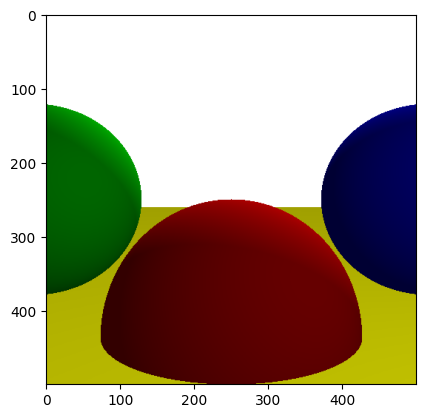

In [5]:
##################################
#
#         RAYTRACER
#
##################################

canvas = Framebuffer(height=Ch, width=Cw)
O = np.array([0, 0, 0])
for x in range(-Cw//2, Cw//2):
    for y in range(-Ch//2, Ch//2):
        D = canvasToViewPort(x, y)
        color = traceRay(O, D, 1, np.inf)
        canvas.putPixel(x, y, color)
canvas.show()
canvas.saveToFile()